In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd
from random import shuffle


In [209]:
# sig1 = pd.read_table('/Users/sehwan/Desktop/datasets/send_out/A.tsv')
sig1 = np.loadtxt('/Users/sehwan/Desktop/datasets/send_out/G.tsv', delimiter='\t')
# sig1
sig1.shape

(2072,)

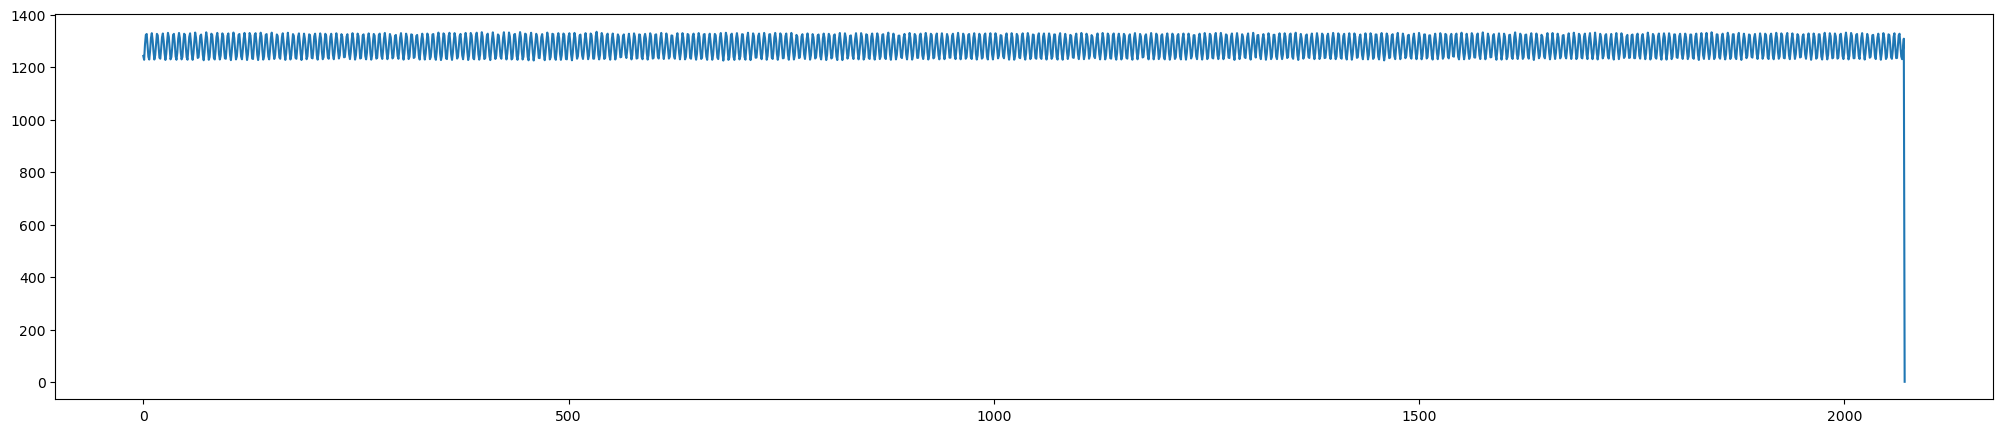

In [210]:
plt.figure(figsize=(25, 5))
plt.plot(sig1)

In [211]:
# model parameters
timesteps = 60
# sampling_frequency = 40
hidden_layer_units = 10

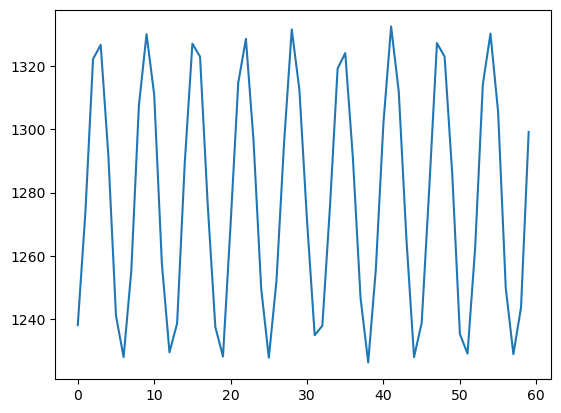

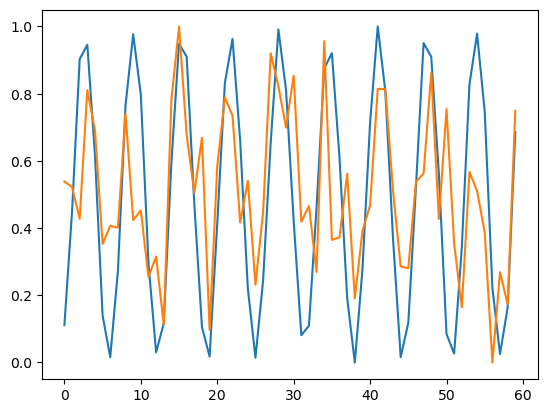

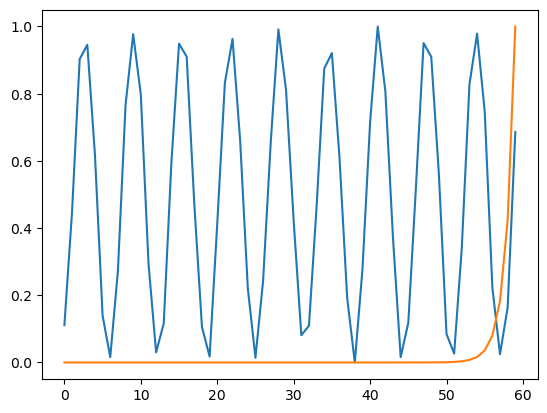

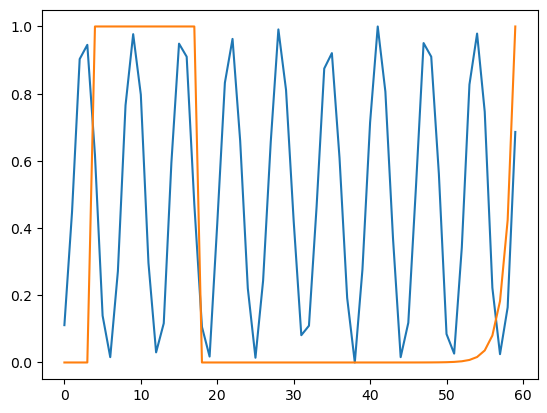

In [212]:
def signal_extraction(data):
    train_input_data_list = []
    train_output_data_list = []

    # loop through the original dataset and perform data extraction/noise addition on each row
    for index in range(len(data) // timesteps):
        # separate the PPG segment in each row into timestep size
        # for index in range(0, 400-timesteps, timesteps):
        # print(index)
        
        if len(data) <= (index + timesteps):
            break

        # ---------- original data, normalized ----------
        
        a = data[index:index + timesteps].copy()
        a = a - np.min(a)
        a = a / np.max(a)

        # ---------- Gaussian noise data ----------
        noise1 = np.random.randn(len(a))/3
        b = a.copy() + noise1
        b = b - np.min(b)
        b = b / np.max(b)

        # ---------- Gaussian noise + low freq noise data ----------
        c = b.copy()
        slope = np.random.randn()
        for i in range(len(c)):
            c[i] = c[i] + slope/len(c)*i
            c = c - np.min(c)
            c = c / np.max(c)

        # ---------- Gaussian noise + low freq noise + saturation data ----------
        d = c.copy()
        location1 = np.random.randint(timesteps)
        location2 = location1 + np.random.randint(timesteps-location1)
        if np.random.rand() > 0:
            d[location1:location2] = np.ones(location2-location1, float)
        else: 
            d[location1:location2] = np.zeros(location2-location1, float)


        # put 80% of the data into the training dataset list, and 20% into the validation dataset list
        # if datanum < 0.8 * len(data):
        if np.sum(np.isfinite(a))== len(a) and np.sum(np.isfinite(d))== len(d):
            train_input_data_list.append(d)  # CHANGE THIS TO THE NOISE-AUGMENTED DATA
            train_output_data_list.append(a)
    # else:
    #   if np.sum(np.isfinite(a))== len(a) and np.sum(np.isfinite(d))== len(d):
    #     val_input_data_list.append(d)  # CHANGE THIS TO THE NOISE-AUGMENTED DATA
    #     val_output_data_list.append(a)

    # plot the last data
    plt.figure()
    plt.plot(data[index:index + timesteps])
    plt.show()
    # plt.figure()
    plt.plot(a)
    plt.plot(b)
    plt.show()
    # plt.figure()
    plt.plot(a)
    plt.plot(c)
    plt.show()
    # plt.figure()
    plt.plot(a)
    plt.plot(d)
    plt.show()

    # convert the dataset lists into arrays
    train_input_data_list = np.asarray(train_input_data_list).reshape([-1, timesteps, 1])
    train_output_data_list = np.asarray(train_output_data_list)
    # val_input_data_list = np.asarray(val_input_data_list)
    # val_output_data_list = np.asarray(val_output_data_list)

    return train_input_data_list, train_output_data_list


[train_input_data_list, train_answer_data_list] = signal_extraction(sig1)

In [213]:
train_input_data_list.shape, train_answer_data_list.shape

((34, 60, 1), (34, 60))

In [214]:
import tensorflow as tf 

def RNN():
    
    model_inputs = tf.keras.Input(shape=(timesteps, 1))
    encoding_layer = tf.keras.layers.LSTM(units=hidden_layer_units, activation='sigmoid', input_shape=(timesteps, 1))(model_inputs)
    out_layer = tf.keras.layers.Dense(units=timesteps, activation='sigmoid')(encoding_layer)

    model = tf.keras.Model(inputs=model_inputs, outputs=out_layer)

    return model

def BiRNN():
    
    model_inputs = tf.keras.Input(shape=(timesteps, 1))
    encoding_layer = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=hidden_layer_units, activation='sigmoid', input_shape=(timesteps, 1)))(model_inputs)
    out_layer = tf.keras.layers.Dense(units=timesteps, activation='sigmoid')(encoding_layer)

    model = tf.keras.Model(inputs=model_inputs, outputs=out_layer)

    return model

def BiRNN_MM():
    
    model_inputs = tf.keras.Input(shape=(timesteps, 1))
    encoding_layer = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=1, activation='sigmoid', input_shape=(timesteps, 1)))(model_inputs)
    out_layer = tf.keras.layers.Dense(units=timesteps, activation='sigmoid')(encoding_layer)

    model = tf.keras.Model(inputs=model_inputs, outputs=out_layer)

    return model

In [215]:
DAE = BiRNN_MM()
DAE.compile(optimizer='adam', loss='mse')

In [216]:
DAE.fit(train_input_data_list, train_answer_data_list, 
        epochs=200, 
        batch_size=32, 
        shuffle=True, 
        # validation_data=(val_input_data_list, val_answer_data_list), verbose=2, callbacks=[cp_callback]
        )


Epoch 1/200
2/2 [==============================] - 3s 22ms/step - loss: 0.1201
Epoch 2/200
2/2 [==============================] - 0s 23ms/step - loss: 0.1201
Epoch 3/200
2/2 [==============================] - 0s 21ms/step - loss: 0.1201
Epoch 4/200
2/2 [==============================] - 0s 24ms/step - loss: 0.1201
Epoch 5/200
2/2 [==============================] - 0s 22ms/step - loss: 0.1200
Epoch 6/200
2/2 [==============================] - 0s 20ms/step - loss: 0.1200
Epoch 7/200
2/2 [==============================] - 0s 23ms/step - loss: 0.1200
Epoch 8/200
2/2 [==============================] - 0s 23ms/step - loss: 0.1200
Epoch 9/200
2/2 [==============================] - 0s 21ms/step - loss: 0.1200
Epoch 10/200
2/2 [==============================] - 0s 21ms/step - loss: 0.1200
Epoch 11/200
2/2 [==============================] - 0s 21ms/step - loss: 0.1200
Epoch 12/200
2/2 [==============================] - 0s 20ms/step - loss: 0.1200
Epoch 13/200
2/2 [==============================]

In [217]:
pred = DAE.predict(train_input_data_list)

2/2 [==============================] - 0s 7ms/step


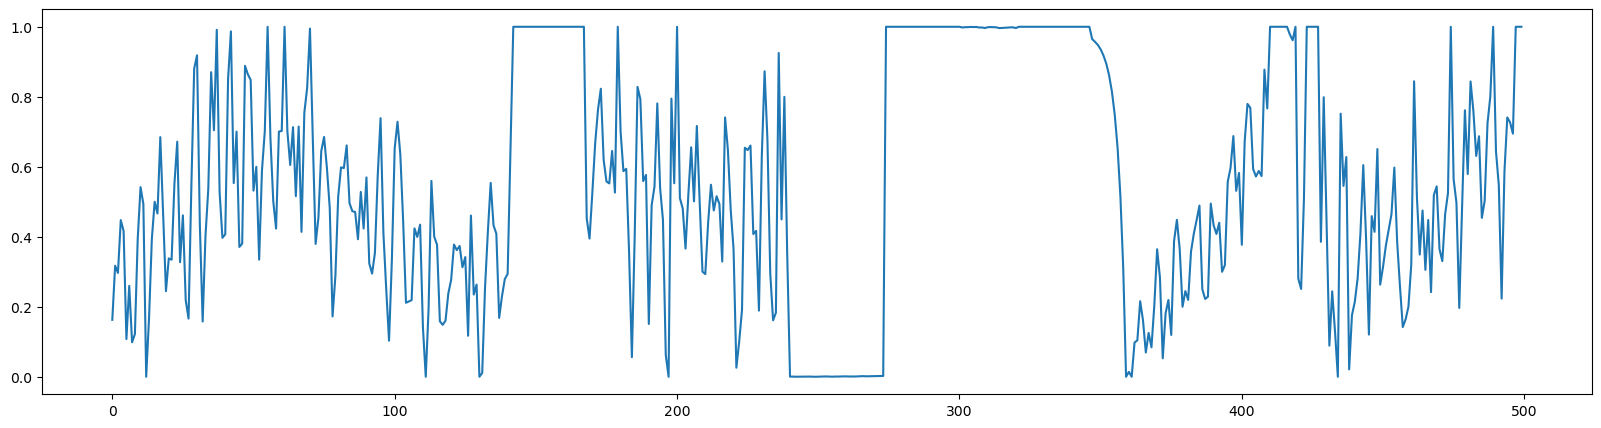

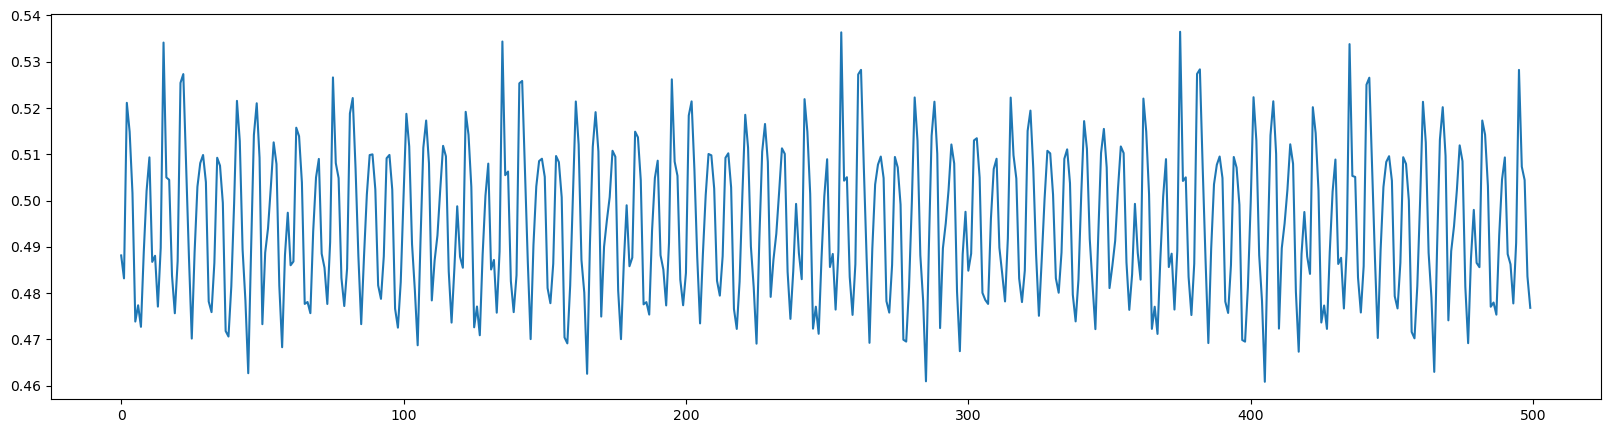

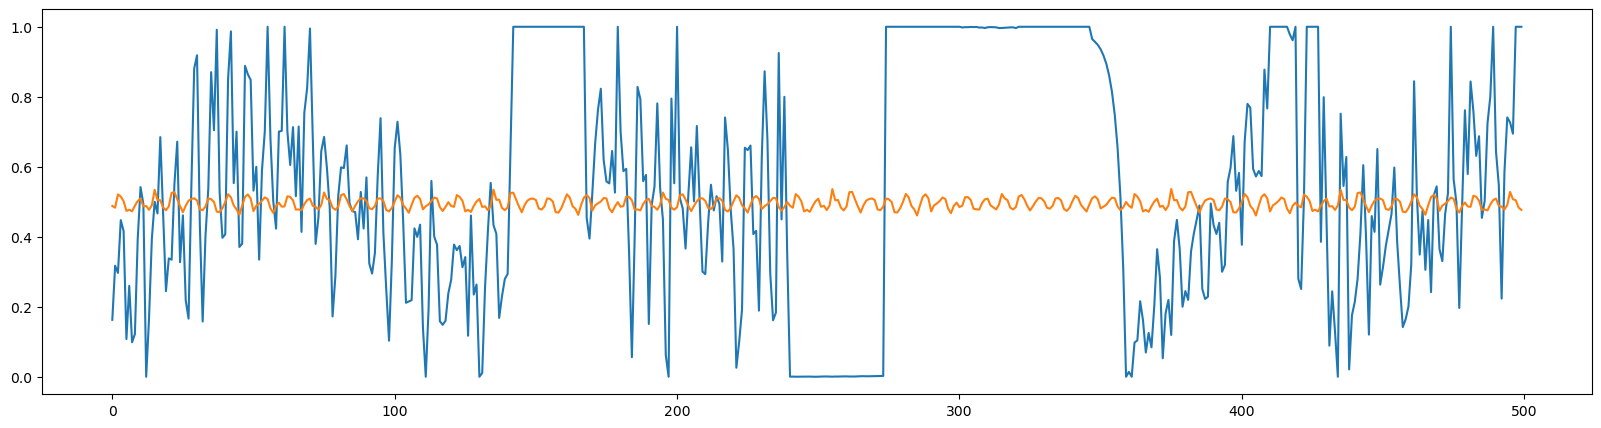

In [218]:
maxlen = 500

plt.figure(figsize=(20, 5))
plt.plot(train_input_data_list.flatten()[:maxlen])
plt.show()

plt.figure(figsize=(20, 5))
plt.plot(pred.flatten()[:maxlen])
plt.show()

plt.figure(figsize=(20, 5))
plt.plot(train_input_data_list.flatten()[:maxlen])
plt.plot(pred.flatten()[:maxlen], '-')
plt.show()

In [219]:
def signal_extraction2(data):
    signals = []
    # loop through the original dataset and perform data extraction/noise addition on each row
    for index in range(len(data) // timesteps):
        # separate the PPG segment in each row into timestep size
        # for index in range(0, 400-timesteps, timesteps):
        start = index * timesteps
        end = (index * timesteps) + timesteps

        # ---------- original data, normalized ----------
        a = data[start:end].copy()
        # a = a - np.min(a)
        # a = a / np.max(a)
        
        signals.append(a) 


    return np.array(signals).reshape([-1, timesteps])

result_data_list = signal_extraction2(sig1)

In [220]:
result_data_list.shape

(34, 60)

In [221]:
# train_answer_data_list.shape
sig1_pred = DAE.predict(np.expand_dims(result_data_list, axis=-1))
sig1_pred.shape

2/2 [==============================] - 0s 7ms/step


(34, 60)

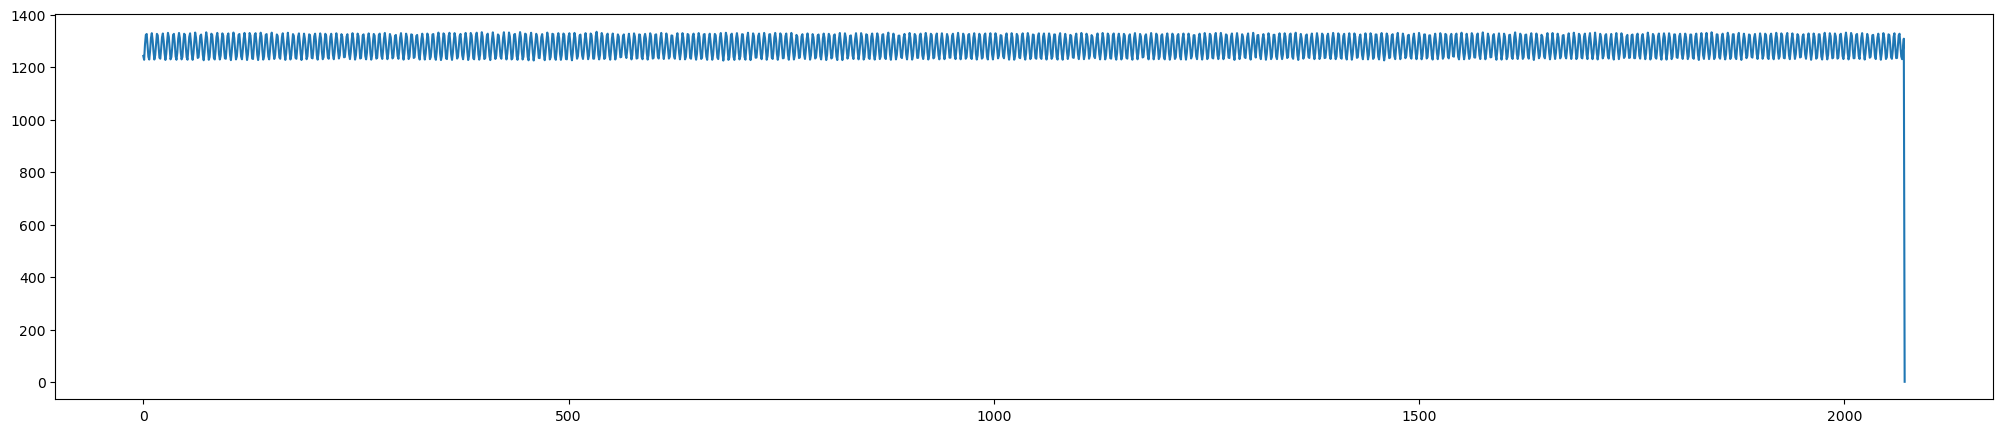

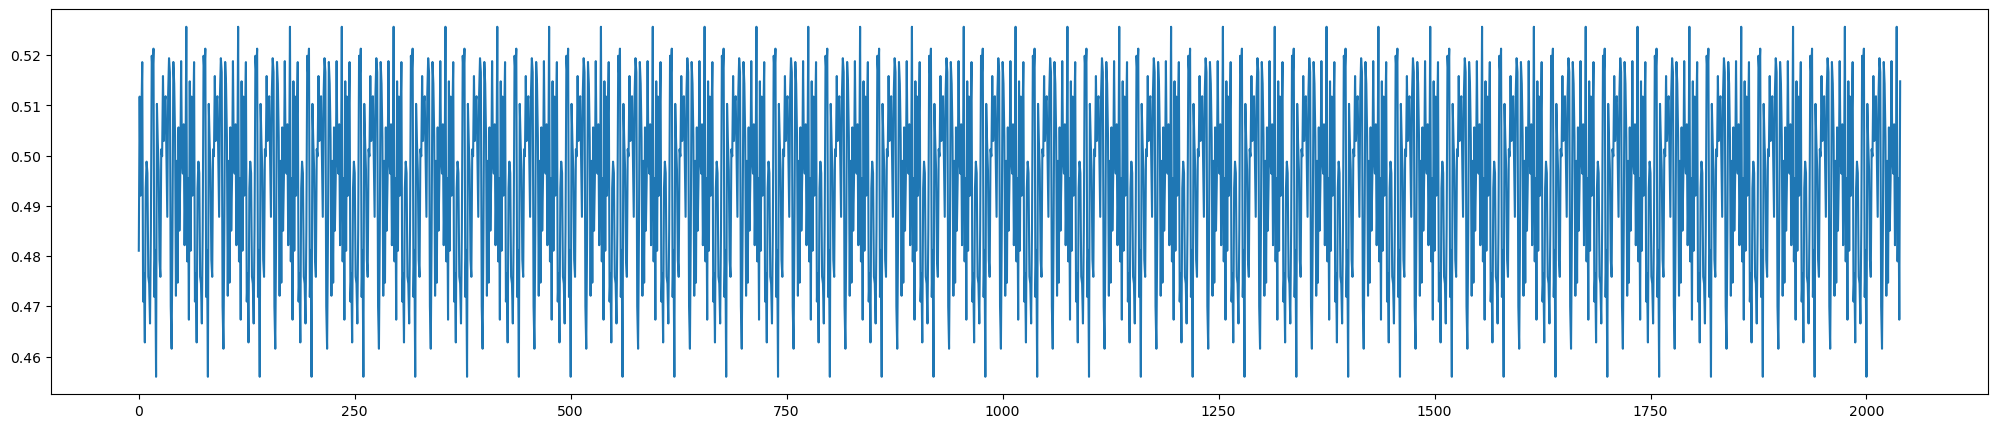

In [222]:
plt.figure(figsize=(25, 5))
plt.plot(sig1.flatten())
plt.show()

plt.figure(figsize=(25, 5))
plt.plot(sig1_pred.flatten())
plt.show()

In [223]:
np.savetxt('G.out', sig1_pred.flatten())

In [51]:
train_input_data_list.shape
test = train_input_data_list.flatten()
test.shape

(3060,)

In [12]:
pred_test = pred.flatten()

In [60]:
from scipy.io.wavfile import write

# WAV 파일로 저장
write("output3.wav", 5000, train_answer_data_list.flatten())
write("output4.wav", 5000, pred.flatten())
